In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, time
from bs4 import BeautifulSoup
from scipy.stats import lognorm, norm, gamma

### Initial Timeline & Bootstrap

In [ ]:
# Setting urls from 2010 to 2023
win23url = 'https://weatherspark.com/h/s/491/2023/3/Historical-Weather-Winter-2023-in-Berkeley-United-States'
urls = []
for n in range(1950, 2024):
    if n == 2023:
        url = win23url
    else:
        url = win23url.replace('2023', str(n))
    urls.append(url)

In [ ]:
# Scraping daily precip data from each year
dfs = []
for url in urls:
    time.sleep(0.5)
    response = requests.get(url, timeout=20)
    soup = BeautifulSoup(response.text, 'html.parser')
    div = soup.find('div', class_='flex_center')
    table = div.find('table')
    df = pd.read_html(str(table))[0]
    df['Precipitation'] = df['Precipitation'].fillna('0.00 in')
    df['Precipitation'] = pd.to_numeric(df['Precipitation'].str[:-3])
    dfs = dfs + [df]

Text(0, 0.5, 'Inches')

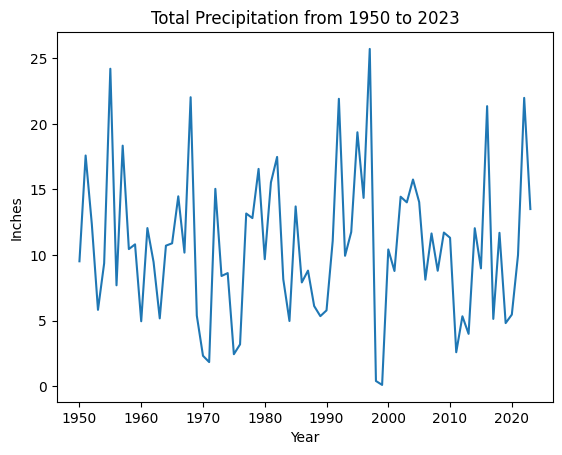

In [ ]:
# Plotting total precip against year
total_precip = [np.sum(df['Precipitation']) for df in dfs]
plt.plot(range(1950, 2024), total_precip)
plt.title('Total Precipitation from 1950 to 2023')
plt.xlabel('Year')
plt.ylabel('Inches')

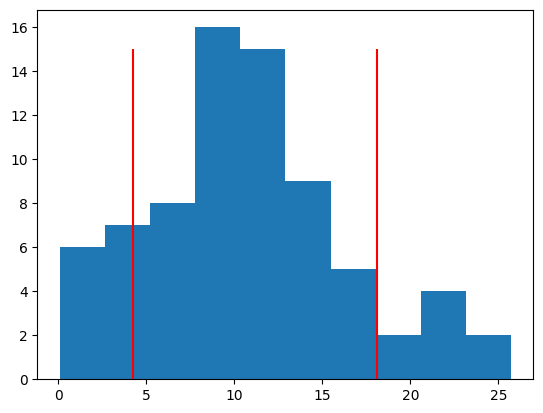

In [ ]:
# distribution of precipitation of all years
plt.hist(total_precip)
plt.vlines(np.percentile(total_precip, 10), 0, 15, color='red')
plt.vlines(np.percentile(total_precip, 90), 0, 15, color='red')

In [ ]:
# initial 80% CI
[np.percentile(total_precip, 10), np.percentile(total_precip, 90)]

[4.246, 18.115000000000006]

In [ ]:
# look at years that are in the middle
middle_range = np.percentile(total_precip, [10, 90])
middle_vals = [x for x in total_precip if x > middle_range[0] and x < middle_range[1]]
precip_years = dict(zip(range(1950, 2024), total_precip))
middle_years = [x for x in precip_years if precip_years[x] in middle_vals]

# look at years that are on the edge
edge_years = [x for x in precip_years if precip_years[x] not in  middle_vals]

Text(0, 0.5, 'Inches')

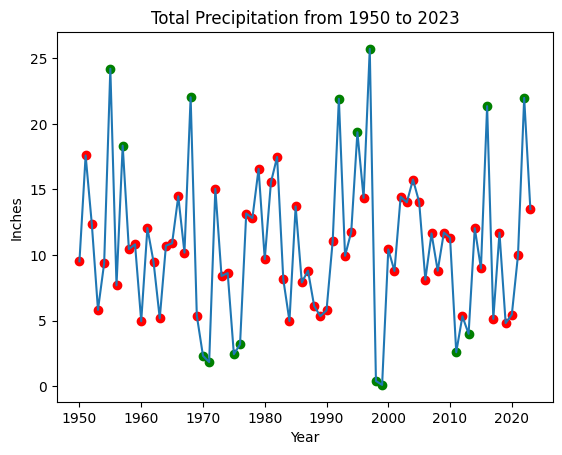

In [ ]:
# plot years and group by middle or edge
plt.plot(range(1950, 2024), total_precip)
plt.scatter(middle_years, [precip_years[x] for x in middle_years], color='red')
plt.scatter(edge_years, [precip_years[x] for x in edge_years], color='green')
plt.title('Total Precipitation from 1950 to 2023')
plt.xlabel('Year')
plt.ylabel('Inches')

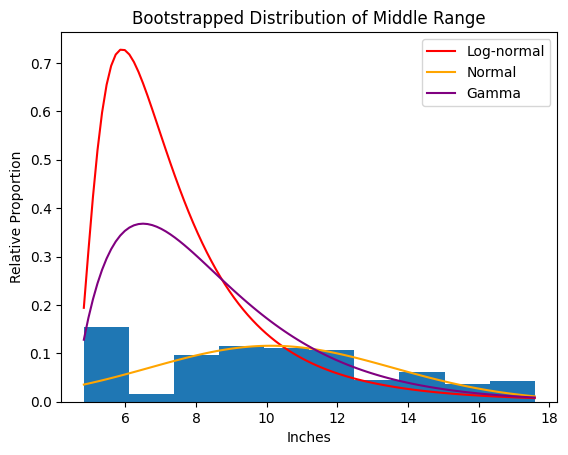

In [ ]:
# bootstrap distribution and see what the distribution looks like
# can do bootstrap since we have enough rows of data
np.random.seed(5)
sample = np.random.choice(middle_vals, 1000) 
# use the middle values since we think this decade will be in the middle range

sd = np.std(sample)
mean = np.mean(sample)
x = np.linspace(np.min(sample), np.max(sample), 100)
s = 0.7
x2 = np.linspace(lognorm.ppf(0.01, s), lognorm.ppf(0.99, s), 100)
a = 2
x3 = np.linspace(gamma.ppf(0.01, a), gamma.ppf(0.99, a), 100)

plt.hist(sample, density=True)
plt.plot(x, lognorm.pdf(x2, s), color= 'red')
plt.plot(x, norm.pdf(x, mean, sd), color='orange')
plt.plot(x, gamma.pdf(x3, a), color= 'purple')
plt.legend(['Log-normal', 'Normal', 'Gamma'])
plt.title('Bootstrapped Distribution of Middle Range')
plt.ylabel('Relative Proportion')
plt.xlabel('Inches')
plt.show()

In [ ]:
# new 80% CI
norm.interval(0.8, mean, sd)

(5.701912441778627, 14.54492755822137)

### Classifying by ENSO Patterns

In [ ]:
el_nino = np.array([1958,
1966,
1973,
1978,
1980,
1983,
1987,
1988,
1992,
1995,
1998,
2003,
2007,
2010,
2016])

la_nina = np.array([1950,
1951,
1955,
1956,
1962,
1971,
1974,
1976,
1989,
1999,
2000,
2008,
2011,
2012,
2021,
2022])

## El Nino

In [ ]:
el_nino_percip = np.array(total_precip)[el_nino - 1950]
el_nino_percip

array([10.46, 14.48,  8.41, 12.82,  9.69,  8.16,  8.82,  6.12, 21.91,
       19.36,  0.41, 14.02, 11.65, 11.32, 21.35])

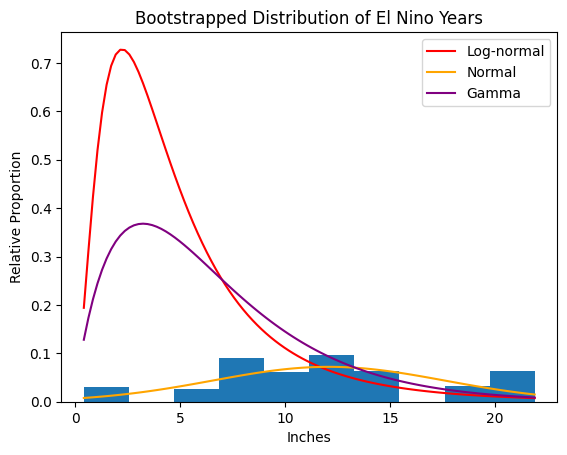

In [ ]:
np.random.seed(5)
sample = np.random.choice(el_nino_percip, 1000) 
# use the middle values since we think this decade will be in the middle range

sd = np.std(sample)
mean = np.mean(sample)
x = np.linspace(np.min(sample), np.max(sample), 100)
s = 0.7
x2 = np.linspace(lognorm.ppf(0.01, s), lognorm.ppf(0.99, s), 100)
a = 2
x3 = np.linspace(gamma.ppf(0.01, a), gamma.ppf(0.99, a), 100)

plt.hist(sample, density=True)
plt.plot(x, lognorm.pdf(x2, s), color= 'red')
plt.plot(x, norm.pdf(x, mean, sd), color='orange')
plt.plot(x, gamma.pdf(x3, a), color= 'purple')
plt.legend(['Log-normal', 'Normal', 'Gamma'])
plt.title('Bootstrapped Distribution of El Nino Years')
plt.ylabel('Relative Proportion')
plt.xlabel('Inches')
plt.show()

In [ ]:
print('The mean and sd of the normal approxiamtion is: ', mean, sd)

The mean and sd of the normal approxiamtion is:  12.08643 5.533103374698507


In [ ]:
print('The weight of el nino is ', len(el_nino)/len(total_precip))

The weight of el nino is  0.20270270270270271


## La Nina

In [ ]:
la_nina_percip = np.array(total_precip)[la_nina - 1950]
la_nina_percip

array([ 9.53, 17.59, 24.2 ,  7.7 ,  9.47,  1.85,  8.63,  3.2 ,  5.35,
        0.11, 10.43,  8.81,  2.6 ,  5.34, 10.  , 21.98])

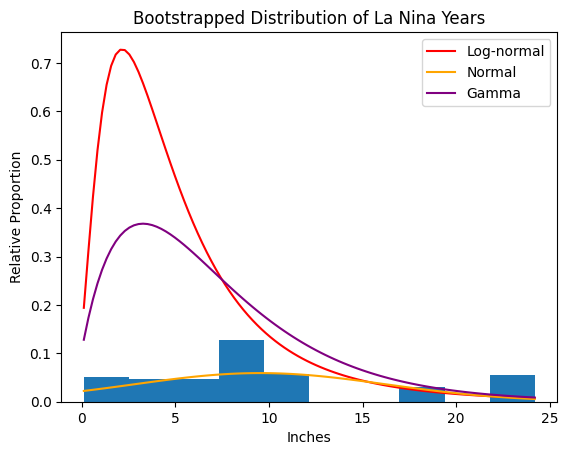

In [ ]:
np.random.seed(5)
sample = np.random.choice(la_nina_percip, 1000) 
# use the middle values since we think this decade will be in the middle range

sd = np.std(sample)
mean = np.mean(sample)
x = np.linspace(np.min(sample), np.max(sample), 100)
s = 0.7
x2 = np.linspace(lognorm.ppf(0.01, s), lognorm.ppf(0.99, s), 100)
a = 2
x3 = np.linspace(gamma.ppf(0.01, a), gamma.ppf(0.99, a), 100)

plt.hist(sample, density=True)
plt.plot(x, lognorm.pdf(x2, s), color= 'red')
plt.plot(x, norm.pdf(x, mean, sd), color='orange')
plt.plot(x, gamma.pdf(x3, a), color= 'purple')
plt.legend(['Log-normal', 'Normal', 'Gamma'])
plt.title('Bootstrapped Distribution of La Nina Years')
plt.ylabel('Relative Proportion')
plt.xlabel('Inches')
plt.show()

In [ ]:
print('The mean and sd of the normal approxiamtion is: ', mean, sd)

The mean and sd of the normal approxiamtion is:  9.521989999999999 6.740984448869467


In [ ]:
print('The weight of la nina is ', len(la_nina)/len(total_precip))

The weight of la nina is  0.21621621621621623


## Neutral

In [ ]:
non_neutral = np.sort(np.concatenate((el_nino, la_nina)))
non_neutral

array([1950, 1951, 1955, 1956, 1958, 1962, 1966, 1971, 1973, 1974, 1976,
       1978, 1980, 1983, 1987, 1988, 1989, 1992, 1995, 1998, 1999, 2000,
       2003, 2007, 2008, 2010, 2011, 2012, 2016, 2021, 2022])

In [ ]:
neutral = np.arange(1950, 2024)[np.isin(np.arange(1950, 2024), non_neutral, invert = True)]
neutral_percip = np.array(total_precip)[neutral - 1950]

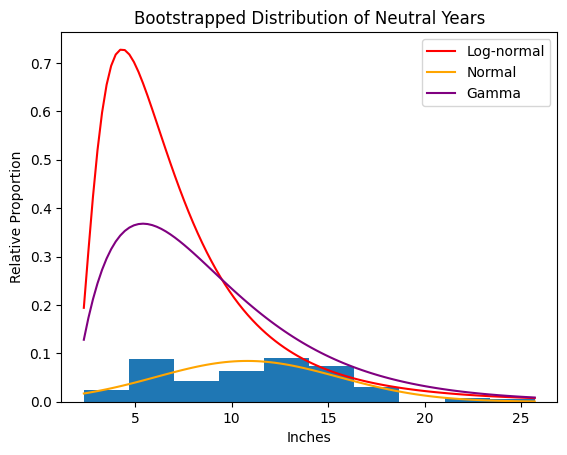

In [ ]:
np.random.seed(5)
sample = np.random.choice(neutral_percip, 1000) 
# use the middle values since we think this decade will be in the middle range

sd = np.std(sample)
mean = np.mean(sample)
x = np.linspace(np.min(sample), np.max(sample), 100)
s = 0.7
x2 = np.linspace(lognorm.ppf(0.01, s), lognorm.ppf(0.99, s), 100)
a = 2
x3 = np.linspace(gamma.ppf(0.01, a), gamma.ppf(0.99, a), 100)

plt.hist(sample, density=True)
plt.plot(x, lognorm.pdf(x2, s), color= 'red')
plt.plot(x, norm.pdf(x, mean, sd), color='orange')
plt.plot(x, gamma.pdf(x3, a), color= 'purple')
plt.legend(['Log-normal', 'Normal', 'Gamma'])
plt.title('Bootstrapped Distribution of Neutral Years')
plt.ylabel('Relative Proportion')
plt.xlabel('Inches')
plt.show()

In [ ]:
print('The mean and sd of the normal approxiamtion is: ', mean, sd)

The mean and sd of the normal approxiamtion is:  10.80289 4.73432657807845


In [ ]:
print('The weight of neutral is ', len(neutral)/len(total_precip))

The weight of neutral is  0.581081081081081


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=323d6726-f80a-43ec-8756-fe4b9370a066' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>